In [1]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
from matplotlib import rc
# import latex
rc("text", usetex=False)

Plot RMSE from cross validation

In [2]:
%load_ext autoreload
%autoreload 2
from basic.plot import plot_error_cv

plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')

In [3]:

def df_return(fp, fn):
    error_stats = pd.read_csv(f'{fp}{fn}', index_col = 'index')
    cols = error_stats.columns
    error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
    error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
    df_temp = error_stats.iloc[:]
    
    return df_temp

In [4]:
# Plot errors of cross-validation
from matplotlib import rcParams

# filepath = ['../output/paper0915/', '../output/paper0915/figure4/test_plot/', '../output/paper0915/figure4/test1013/']
filepath = ['../output/']
filename = ['fix-basis/error_cv_uniform_552.csv', 'fix-basis/error_cv_exact_552.csv', 'fix-basis/error_cv_full_552.csv']

df_uniform = df_return(filepath[0], filename[0])
df_uniform = df_uniform.filter(items=['mean'])
cols = df_uniform.columns
df_uniform.rename(columns={col: col+'_uni' for col in cols if col == 'mean'}, inplace=True)
df_22 = df_return(filepath[0], filename[2])
df_22 = df_22.filter(items=['mean'])
df_22.rename(columns={col: col+'_22' for col in cols}, inplace=True)

df_exact = df_return(filepath[0], filename[1])
df_exact = df_exact.filter(items=['mean'])
df_exact.rename(columns={col: 'mean_exact' for col in cols}, inplace=True)

df = pd.concat([df_uniform, df_exact, df_22], axis=1)

df_cols = df.columns
keys = ['legend', 'legend_low', 'legend_up']
legend_dict = {}
for ind in range(len(keys)):
    legend_dict[keys[ind]] = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==ind]

df = df.reset_index()
# plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

In [49]:
# read results with replicate sampling
df_exact = pd.DataFrame()
filepath = ['../output/']
for ii in range(20):
    fname = f'random/{ii}/error_cv_exact_552.csv'
    df_temp = df_return(filepath[0], fname)
    df_temp = df_temp.filter(items=['mean'])
    cols = df_temp.columns
    df_temp.rename(columns={col: f'mean_replicate{ii}' for col in cols}, inplace=True)
    df_exact = pd.concat([df_temp, df_exact], axis=1)
df = df_exact

In [50]:
train_vals = pd.read_csv(filepath[0]+'adaptive/samples_adjust.csv').values[:, -1]
xticks = np.array([int(i.split('_')[1]) for i in list(df.index)])
std_list = [train_vals[0:].std() for n in xticks]

In [51]:
# calculate the relative RMSE which is the RMSE normalized by the standard deviation
df = df_exact
for col in df.columns[0:]:
    df.loc[:, col] = df.loc[:, col] / std_list
# df.head()

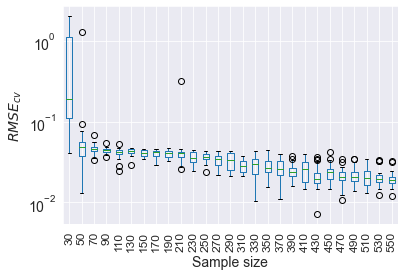

In [53]:
ax = df[:].T.boxplot()
ax.set_xticklabels(np.arange(30, 551, 20), rotation=90, fontsize=12);
ax.set_yscale('log')
ax.set_xlabel('Sample size', fontsize=14)
ax.set_ylabel(r'$RMSE_{cv}$', fontsize=14)
plt.savefig('../output/adaptive/figure/adaptive_replicate20.png', dpi=300, format='png')

## Bar plot of sensitivity indices

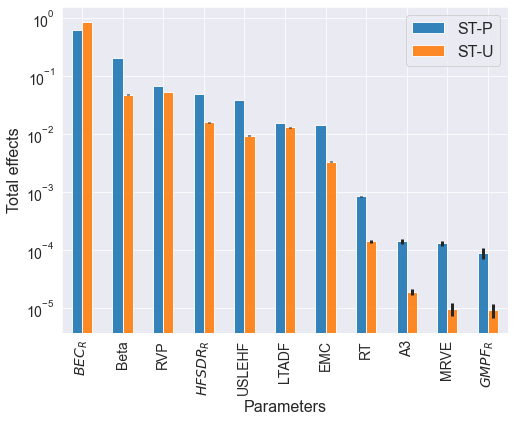

In [57]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/adaptive/'
df_plot = pd.read_csv(f'{filepath}sa_fig.csv', index_col= 'Unnamed: 0')
cols = df_plot.columns
legend = ['ST', 'ST_Uniform']
legend_low = [lab+'_lower' for lab in legend]
legend_up = [lab+'_upper' for lab in legend]
for lab in legend:
    df_plot.loc[:, f'{lab}_lower'] = df_plot.loc[:, lab] - df_plot.loc[:, f'{lab}_lower'] 
    df_plot.loc[:, f'{lab}_upper'] = df_plot.loc[:, f'{lab}_upper'] - df_plot.loc[:, lab]

sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=legend, kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_plot.shape[0]), alpha=0.9)
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16); 
xticks = df_plot.short_name.values
xticks[0] = r'$BEC_R$'; xticks[3] = r'$HFSDR_R$'; xticks[-1] = r'$GMPF_R$'
ax.set_xticklabels(df_plot.short_name.values, rotation=90, fontsize=14);
ax.legend(['ST-P', 'ST-U'])
plt.savefig(f'{filepath}figure/Figure5-log-bar.png', format='png', dpi=300, bbox_inches='tight') 

## Plot Figure 7

In [5]:
# calculate the changes in the confidence intervals
# heat map 
# filepath = '../output/paper0915/error_measures/1029_cal/'
product_uniform = 'exact'
filepath = f'../output/adaptive/{product_uniform}/'
filename = ['cf_width', 'cf_width_lower', 'cf_width_upper']
df_mean = pd.read_csv(f'{filepath}{filename[0]}.csv', index_col = 'Unnamed: 0')
df_lower = pd.read_csv(f'{filepath}{filename[1]}.csv', index_col = 'Unnamed: 0')
df_upper = pd.read_csv(f'{filepath}{filename[2]}.csv', index_col = 'Unnamed: 0')
df_lower = 1 - df_lower
cols = df_mean.columns
for col in cols:
    ind = df_mean[df_mean[col]>1].index.tolist()
    if len(ind) > 0: df_lower.loc[ind, col] = 1 - df_upper.loc[ind, col]
# df_lower.to_csv(f'{filepath}cf_changes.csv', index=True)

Line plot for three error measures

In [6]:
# prepare the data for plot: confidence intervals and the coefficient of variation
# filepath = '../output/paper0915/error_measures/1029_cal/'
filepath = f'../output/adaptive/{product_uniform}/'
path_save = '../output/adaptive/figure'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_70']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed

In [7]:
# df.drop_duplicates(subset='cv', keep='first', inplace=True)
# import unconditional stats
with open(f'{filepath}y_uncond_stats.json', 'r') as fp:
    uncond_stats = json.load(fp)
uncond_stats =  uncond_stats['nsample_70']
df.loc[11, 'Num of parameters fixed'] = 0
df.loc[11, 'cf_upper'] = uncond_stats['uncond_cf_up']['mean']
df.loc[11, 'cf_lower'] = uncond_stats['uncond_cf_low']['mean']
df.loc[11, 'cv'] = uncond_stats['cv']
df.loc[11, 'ks'] = 0
df.loc[11, 'pvalue'] = 1
df.loc[11, 'cf_upper_upper'] = uncond_stats['uncond_cf_up']['up']
df.loc[11, 'cf_upper_lower'] = uncond_stats['uncond_cf_up']['low']
df.loc[11, 'cf_lower_upper'] = uncond_stats['uncond_cf_low']['up']
df.loc[11, 'cf_lower_lower'] = uncond_stats['uncond_cf_low']['low']
df.loc[11, 'cond_mean'] = uncond_stats['uncond_mean']

In [8]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 1.96 * df['cv']

# drop duplicates
df.drop_duplicates(subset='cv', keep='first', inplace = True)

In [9]:
df

,Num of parameters fixed,cf_upper,cf_lower,cv,ks,pvalue,cf_upper_upper,cf_upper_lower,cf_lower_upper,cf_lower_lower,...,upper_mean,upper_mean_lower,upper_mean_upper,lower_mean,lower_mean_lower,lower_mean_upper,cf_median_mean,cf_median_lower,cf_median_upper,cf_cv
0,11.0,2.776774e+07,2.776774e+07,0.000000,0.570478,2.620643e-127,2.777034e+07,2.776422e+07,2.777034e+07,2.776422e+07,...,0.000049,-0.000078,0.000143,-0.000049,0.000078,-0.000143,1.341589e-16,0.000127,-0.000093,0.000000
1,10.0,3.515584e+07,2.257860e+07,0.083574,0.130968,1.620341e-06,3.574507e+07,3.445149e+07,2.280114e+07,2.239834e+07,...,0.265058,0.239712,0.286261,0.187525,0.194012,0.179517,2.178464e-01,0.224091,0.210137,0.163806
2,9.0,3.543386e+07,2.028707e+07,0.124562,0.047223,2.426509e-01,3.647773e+07,3.459777e+07,2.084912e+07,1.988089e+07,...,0.298580,0.267940,0.336836,0.256519,0.271405,0.235921,2.718331e-01,0.286412,0.251659,0.244141
3,8.0,3.603355e+07,2.014466e+07,0.140372,0.037813,4.931649e-01,3.649996e+07,3.551265e+07,2.052956e+07,1.983484e+07,...,0.319850,0.300770,0.336934,0.262134,0.273482,0.248036,2.828300e-01,0.293860,0.269128,0.275129
4,7.0,3.586529e+07,1.994771e+07,0.144180,0.031072,7.138522e-01,3.651767e+07,3.526415e+07,2.035616e+07,1.945379e+07,...,0.313706,0.291687,0.337602,0.269337,0.287429,0.254376,2.851948e-01,0.302894,0.270558,0.282592
5,6.0,3.582323e+07,1.976662e+07,0.148818,0.027711,8.181903e-01,3.704092e+07,3.526701e+07,2.018314e+07,1.934972e+07,...,0.311674,0.291308,0.356260,0.276242,0.291507,0.260990,2.888406e-01,0.303840,0.273855,0.291683
6,5.0,3.609277e+07,1.980427e+07,0.153216,0.024269,9.074149e-01,3.674945e+07,3.556738e+07,2.010727e+07,1.926549e+07,...,0.321410,0.302175,0.345452,0.274936,0.294662,0.263843,2.914018e-01,0.310679,0.280560,0.300304
7,4.0,3.619054e+07,1.975774e+07,0.155687,0.015180,9.986156e-01,3.669576e+07,3.578524e+07,2.018966e+07,1.934393e+07,...,0.324971,0.310133,0.343468,0.276650,0.291800,0.260837,2.937141e-01,0.308507,0.278274,0.305146
8,3.0,3.621778e+07,1.973091e+07,0.156375,0.013321,9.996377e-01,3.664510e+07,3.580541e+07,2.017546e+07,1.932972e+07,...,0.325758,0.310663,0.341400,0.277747,0.292432,0.261474,2.946784e-01,0.309020,0.278787,0.306494
9,2.0,3.621564e+07,1.971990e+07,0.154829,0.013358,9.995899e-01,3.668360e+07,3.573588e+07,2.016670e+07,1.936956e+07,...,0.325728,0.308166,0.342859,0.278123,0.290948,0.261767,2.949063e-01,0.307433,0.278931,0.303465


C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


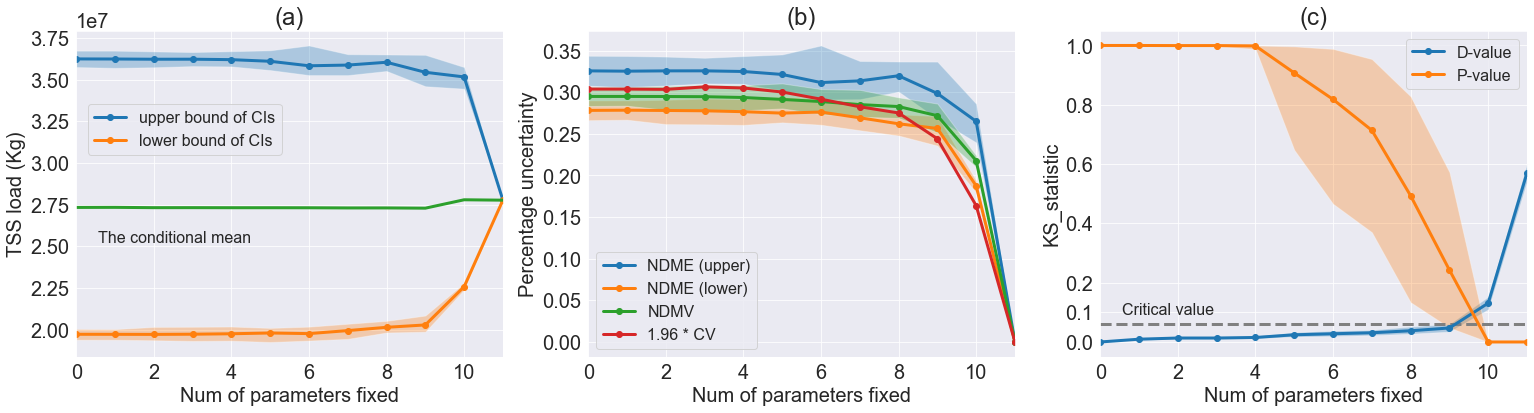

In [11]:
# Line plot
plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')
fs = 16
fig, axes = plt.subplots(1, 3, sharex=True)
x_col = 'Num of parameters fixed'
ax = df.plot(x=x_col, y=filename[0:2], 
            figsize=(26, 6), marker='o', ax=axes[0])
ax.fill_between(df.loc[:, x_col], df.cf_upper_lower, df.cf_upper_upper, alpha=0.3)
ax.fill_between(df.loc[:, x_col], df.cf_lower_lower, df.cf_lower_upper, alpha=0.3)            
             
ax.plot(df.loc[:, x_col], df.cond_mean)          
ax.text(0.05, 0.35, 'The conditional mean', transform=ax.transAxes, fontsize=fs) #c='k',

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.5, 0.8))
ax.set_title("(a)", loc='center', fontsize=24)

ax1 = df.plot(x_col, ['upper_mean', 'lower_mean', 'cf_median_mean', 'cf_cv'], marker='o', ax=axes[1])
ax1.fill_between(df.loc[:, x_col], df.upper_mean_lower, df.upper_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.lower_mean_lower, df.lower_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.cf_median_lower, df.cf_median_upper, alpha=0.3)
ax1.set_ylabel('Percentage uncertainty') 
ax1.legend(['NDME (upper)', 'NDME (lower)', 'NDMV', '1.96 * CV'], fontsize=fs)
ax1.set_title("(b)", loc='center', fontsize=24);

ax2 = df.plot(x_col,['ks', 'pvalue'], marker='o', ax=axes[2])
ax2.fill_between(df.loc[:, x_col], df.ks_lower, df.ks_upper, alpha=0.3)
ax2.fill_between(df.loc[:, x_col], df.pvalue_lower, df.pvalue_upper, alpha=0.3)
ax2.hlines(0.061, xmin=0, xmax=11, linestyle = '--', color='grey')          
ax2.text(0.05, 0.13, 'Critical value', transform=ax2.transAxes, fontsize=fs) #c='k',
ax2.set_xlim(*x_range)
ax2.set_yticks([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('KS_statistic')
ax2.legend(['D-value', 'P-value'], fontsize=fs) ;
ax2.set_xlabel(x_col);
ax2.set_title("(c)", loc='center', fontsize=24);
plt.savefig(f'{path_save}/{product_uniform}_figure7_uncertainty_communication.png', format='png', dpi=300, bbox_inches='tight')

## Figure 8 Line plot for showing robustness of error estimation

In [18]:
# Adaptive evaluation of error measure
# filepath = '../output/paper0915/error_measures/1029_cal/'
product_uniform = 'exact'
filepath = f'../output/adaptive/{product_uniform}/'
path_save = '../output/adaptive/figure'
filename = ['cf_lower_adaptive_70', 'cf_lower_lower_adaptive_70', 'cf_lower_upper_adaptive_70',
            'cf_upper_adaptive_70', 'cf_upper_lower_adaptive_70', 'cf_upper_upper_adaptive_70', 'cond_mean_adaptive_70']# 'stats_uncond_adaptive'

In [19]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename[:]:
    print(fn)
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[2]
# df.loc[:, 'median'] = (df.loc[:, filename[0]] + df.loc[:, filename[3]]) / 2 # only use the mean of CIs for calculation

cf_lower_adaptive_70
cf_lower_lower_adaptive_70
cf_lower_upper_adaptive_70
cf_upper_adaptive_70
cf_upper_lower_adaptive_70
cf_upper_upper_adaptive_70
cond_mean_adaptive_70


In [26]:
df_ratio = pd.DataFrame(index=df.index, columns=df.columns)
cols = df.columns
for fn in filename[:-1]:
    if 'cf_lower' in fn:
        df_ratio.loc[:, fn] = (df.loc[:, cols[-1]] - df.loc[:, fn]) / df.loc[:, cols[-1]]
    else:
        df_ratio.loc[:, fn] = (df.loc[:, fn] - df.loc[:, cols[-1]]) / df.loc[:, cols[-1]]
df_ratio.loc[:, cols[-1]] = df.loc[:,cols[-1]]

cf_lower_adaptive_70
cf_lower_lower_adaptive_70
cf_lower_upper_adaptive_70


C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
<ipython-input-28-49e341a3a4a9>:31: MatplotlibDeprecationWarning: savefig

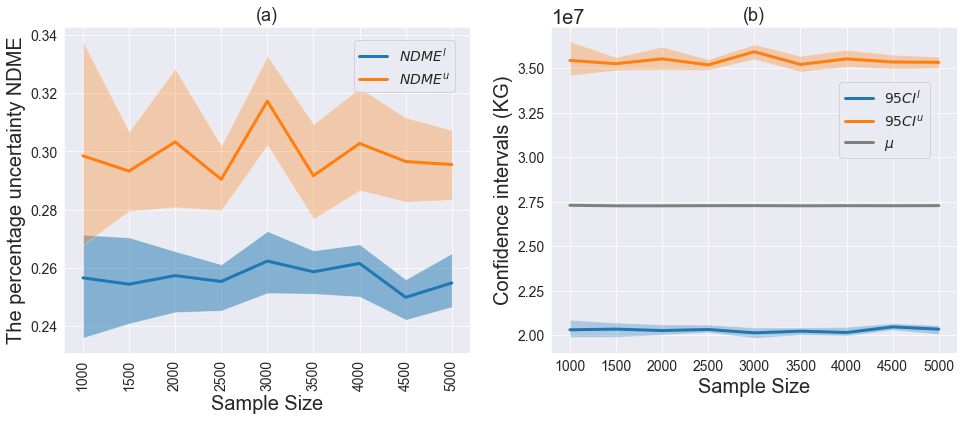

In [28]:

plt.rcParams.update({'font.size': 8})
fs=14
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2)
ind = list(df.index)
df = df.loc[ind[0:9], :]
ind = list(df.index)

ax1 = df_ratio.loc[ind, cols[[0, 3]]].plot(ax=axes[0])
plt.sca(axes[1])
plt.xticks(range(len(df.index)), df_ratio.index[0:9], rotation=90)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.fill_between(df.index, df_ratio.loc[ind,cols[1]], df_ratio.loc[ind, cols[2]], alpha=0.5)
ax1.fill_between(df.index, df_ratio.loc[ind, cols[4]], df_ratio.loc[ind, cols[5]], alpha=0.3)
ax1.set_xlabel('Sample Size');
ax1.set_ylabel('The percentage uncertainty NDME');
ax1.legend([f'$NDME^l$', f'$NDME^u$'], bbox_to_anchor=[0.98, 0.98], fontsize=fs);
ax1.set_title('(a)', loc='center', fontsize=18)

ax = df[cols[[0, 3]]].plot(figsize=(16, 6), ax=axes[1])
plt.sca(axes[0])
df[cols[-1]].plot(ax=ax, color='grey')
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.3)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.3)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend([f'$95CI^l$', f'$95CI^u$', r'$\mu$'], bbox_to_anchor=[0.95, 0.85], fontsize=fs)
ax.set_title('(b)', loc='center', fontsize=18);
plt.savefig(f'{path_save}/{product_uniform}_conf_adaptive_two_panels_5000.png', format='png', dpi=300, layout='tight')

## Compare results from different factor fixing practice

In [9]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/adaptive/exact/'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']
# get data in the corresponding column
num_params = 11
col_filter = ['nsample_70']
df_framework = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params]
for f in filename:
    df_framework[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df_framework.index = np.arange(df_framework.shape[0], 0, -1)
df_framework.index.name = 'Num of parameters fixed'
df_framework.reset_index(inplace=True)
# add the one with no parameter fixed

In [10]:
df_plot = pd.DataFrame(columns=df_framework.columns)
df_plot.loc['Framework', :] = df_framework.iloc[2]

In [11]:
# prepare the data for plot: confidence intervals and the coefficient of variation
files = ['thsd_1', 'thsd_10']
index_files = ['threshold (0.01)', 'threshold (0.1)']
for ii in range(len(files)):
    fn = files[ii]
    filepath = f'../output/adaptive/{fn}/'
    filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
    'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
    'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']
    # get data in the corresponding column
    num_params = 22
    col_filter = ['nsample_190']
    df_1 = pd.DataFrame(index=np.arange(num_params), columns=filename)
    x_range = [0, num_params]
    for f in filename:
        df_1[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
    df_1.index = np.arange(df_1.shape[0], 0, -1)
    df_1.index.name = 'Num of parameters fixed'
    df_1.reset_index(inplace=True)
    # add the one with no parameter fixed
    df_plot.loc[index_files[ii], :] = df_1.iloc[0]

In [12]:
filepath = '../output/adaptive/'
# load uncond file
df_plot = df_plot.T
with open(f'{filepath}exact/y_uncond_stats.json', 'r') as fp:
    uncond = json.load(fp)
key_nsample = 'nsample_70'
df_plot.loc['cf_upper', 'uncond'] = uncond[key_nsample]['uncond_cf_up']['mean']
df_plot.loc['cf_upper_upper', 'uncond'] = uncond[key_nsample]['uncond_cf_up']['up']
df_plot.loc['cf_upper_lower', 'uncond'] = uncond[key_nsample]['uncond_cf_up']['low']
df_plot.loc['cf_lower', 'uncond'] = uncond[key_nsample]['uncond_cf_low']['mean']
df_plot.loc['cf_lower_upper', 'uncond'] = uncond[key_nsample]['uncond_cf_low']['up']
df_plot.loc['cf_lower_lower', 'uncond'] = uncond[key_nsample]['uncond_cf_low']['low']
df_plot.loc['cond_mean', 'uncond'] = uncond[key_nsample]['uncond_mean']
df_plot.loc['cv', 'uncond'] = uncond[key_nsample]['cv']
df_plot.loc[['ks', 'ks_upper', 'ks_lower'], 'uncond'] = 0
df_plot.loc[['pvalue', 'pvalue_upper', 'pvalue_lower'], 'uncond'] = 1


In [13]:
# combine df_plot and results of fixing 9 factors by using the framework
df = df_plot
df.dropna(axis=0, inplace=True)
# change the order of columns so that the unconditional value is in the first column
cols = df.columns
columnsTitles = [cols[3], *cols[1:3], cols[0]]
df = df.reindex(columns=columnsTitles)
df = df.T

In [14]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 1.96 * df['cv']
df.reset_index(inplace=True)
df['x_shift'] = df.index + 0.1

In [16]:
df['ks']

0            0
1    0.0206284
2    0.0636392
3    0.0472235
Name: ks, dtype: object

C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting

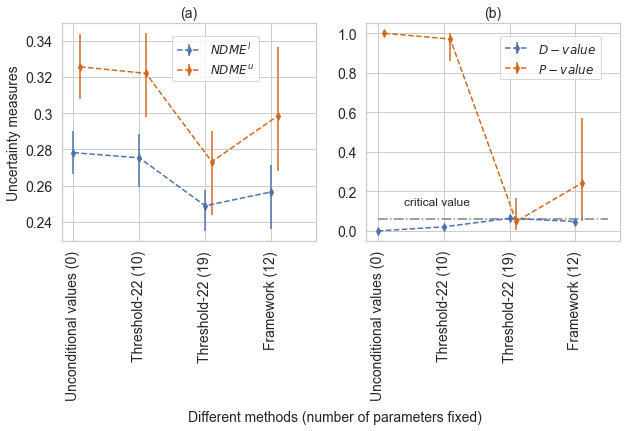

In [18]:
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=[10,4], sharey=False, sharex=True)
markers = ['d']
colors = ['b', 'chocolate']
metrics = ['lower_mean', 'upper_mean','ks', 'pvalue'] #'cf_cv', 'cf_upper', 'cf_lower'
ldg = [r'$NDME^l$', r'$NDME^u$', r'$D-value$', r'$P-value$'] #, '1.96*CV'
subplot_titles = ['a', 'b']

k = 0
for col in metrics:
    ax_index = int(k // 2)
    if k % 2 == 0:
        df.plot(ax=axes[ax_index], y=col, marker=markers[0], color=colors[0], 
            legend=False, linestyle='--', markersize=5, yerr=[(df[col] - df[col + '_lower']).values, (df[col+'_upper'] - df[col]).values]);
    else:
        df.plot(ax=axes[ax_index], x='x_shift', y=col, marker=markers[0], color=colors[1], 
            legend=False, linestyle='--', markersize=5, yerr=[(df[col] - df[col + '_lower']).values, (df[col+'_upper'] - df[col]).values]);
    k += 1
       
axes[0].legend(markers, labels=ldg[0:2], fontsize=12, bbox_to_anchor = (0.8, 0.97))
axes[1].legend(markers, labels=ldg[2:], fontsize=12, bbox_to_anchor = (0.95, 0.97))
for ii in range(2):
    axes[ii].set_xticklabels([-1, 'Unconditional values (0)', 'Threshold-22 (10)', 'Threshold-22 (19)', 'Framework (12)'], size=14, rotation=90) 
    axes[ii].set_title(f'({subplot_titles[ii]})', fontsize=14)
    axes[ii].set_xlabel('')
fig.text(0.6, 0.25, 'critical value', size=12)
fig.text(0.3, -0.5, 'Different methods (number of parameters fixed)', size=14)
axes[0].set_yticklabels(np.round(axes[0].get_yticks(), 2), size=14)
axes[1].set_yticklabels(np.round(axes[1].get_yticks(), 2), size=14)
axes[0].set_ylabel('Uncertainty measures', size=14);
axes[1].hlines(0.060, xmin=axes[1].get_xticks()[1], xmax=axes[1].get_xticks()[-1], linestyle = '-.', color='grey');

plt.savefig(f'{filepath}/figure/Figure10_comp_practices.png', format='png', dpi=300, bbox_inches='tight')

# Plot the sensitivity of 22 parameters 

In [19]:
from basic.plot import short_name

In [20]:
output_path = '../output/adaptive/'
filename = 'sa_pce_22.csv'
sa_22 = pd.read_csv(filepath + filename, index_col='Parameters')
sa_22.reset_index('Parameters', inplace=True)
df_plot = short_name(sa_22)
# calculate the confidence intervals
df_plot.loc[:, 'ST_lower'] = df_plot.loc[:, 'ST'] - df_plot.loc[:, f'ST_lower'] 
df_plot.loc[:, 'ST_upper'] = df_plot.loc[:, 'ST_upper'] - df_plot.loc[:, 'ST']

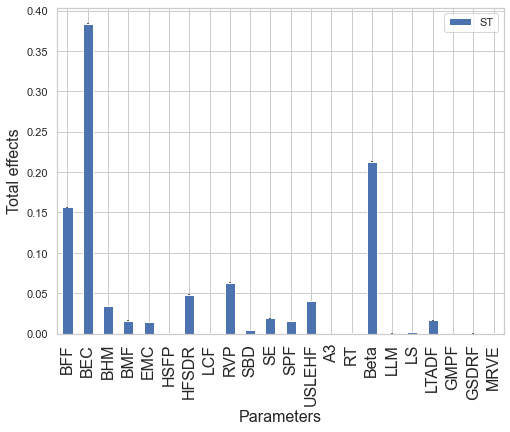

In [22]:
sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y='ST', kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, ['ST_lower', 'ST_upper']].T.values, 
                legend=True, logy=False, xticks=np.arange(df_plot.shape[0]))
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16);
ax.set_xticklabels(df_plot.short_name, fontsize=16);
plt.savefig(f'{output_path}figure/total_effects_22.png', dpi=300, format='png')